# Trist'n Joseph - IST664 - Homework 3

## Introduction

Natural language processing (NLP) is a subfield of linguistics, computer science, and artificial intelligence concerned with the interactions between computers and human language. Generally, NLP refers to the manipulation of natural languages, such as text, by software. In particular, NLP is concerned with how to program computers to process and analyze large amounts of natural language data.

There are vast amounts of text data, and natural language is very nuanced; for example, how should one interpret the phrase “I made her duck”? These issues make NLP very challenging. However, there are also various techniques which could be utilized to combat these challenges.

Within a previous assignments, I explored NLP by collecting and comparing two text documents. After loading the data, I utilized various NLP techniques such as word tokenization, stemming, regular expression filtering, and stop word removal to clean the data and created unigrams, bigrams, and trigrams. Once the data was cleaned, I performed analysis on the text to understand the frequencies and likelihood of words and phrases both within and between the text documents. Additionally, I investigated part-of-speech tagging, and analyzed the distribution of the parts-of-speech identified within the text documents. 

I compared financial articles (hosted on MarketWatch.com) to Hamlet (found within the Gutenberg library in NLTK). I chose to compare these text documents because I hypothesized that there would be a difference in the language used. Financial documents typically present facts to a reader and they do this using statistics and formal language. Hamlet, on the other hand, is presenting a story to a reader, and should use more expressive/emotive language. Therefore, I wanted to test whether my hypotheses were true.
To collect the financial articles, I built a web scraping function that accepts a stock’s ticker symbol and an integer which represents the number of recent articles to collect as input parameters. The function then navigates to a MarketWatch page which has links to all the articles for the input stock. Then the appropriate number of links are collected, based on the input integer. Lastly, the function navigates to the article page for each link collected and saves the title, body, timestamp, and URL for the article in a pandas data frame.  
For text processing, however, the document needed to be in the format of raw text and not within a pandas data frame. Therefore, after collecting the 500 most recent articles about Tesla (ticker symbol TSLA), I combined all articles into one large sample of raw text. 
To load the Hamlet data, I simply navigated to its location within the NLTK library and saved the raw text as a python variable. 

Additionally, I continued to explore NLP by investigating sentiment analysis. Sentiment analysis is a subfield within NLP, and it refers to the classification of emotions within text. This classification allows for the identification of sentiment (or feeling) towards something.
For example, a sentence such as “I am very hard-working” expresses an individual’s belief, where the word “very” is used to amplify/intensify the adjective-phrase “hard-working”. A sentence such as “I am very sad about my grades” expresses the emotion that an individual is disappointed by something, where the word “very” is used to amplify the emotion.
To understand the sentiment within the financial articles and Hamlet, I applied parts-of-speech (POS) tagging to the texts, extracted phrases and sentences related to the POS tags identified, generated summary statistics regarding the phrases, and analyzed the results with respect to the bigrams and trigrams previously identified.

Within this assignment, I continue to explore sentiment analysis. In particular, I uncover whether the sentences within the text (of the financial documents) were negative, positive, or neutral; and I developed models to classify text, given some input parameters. Classifying the text also allowed me to analyze the sentences further -- for each classification, I extracted the POS of the sentence and provided descriptive anlysis to explain the insights.  

## Set up

In [1]:
import string
import re
import nltk
from nltk import FreqDist
from nltk.collocations import *
from nltk import word_tokenize, sent_tokenize
from nltk.stem import LancasterStemmer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.corpus import treebank
from nltk.corpus import sentence_polarity

from textblob import TextBlob

import random

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\trist\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

In [2]:
# financial articles
raw_article_text_path = open("C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST664/Assignments/Homework 1/article_text.txt")
raw_article_text = raw_article_text_path.read()

In [3]:
def ug__regex_pattern_match(words):
    """
    """    
    ug__regex_pattern = re.compile('^[^a-z]+$')
    if (ug__regex_pattern.match(words)):
        return True
    else:
        return False
    
def bg__regex_tokenize(words):
    """
    """  
    pattern = r''' (?x)
        (?:[A-Z]\.)+
        | (?:--+)
        | \w+(?:-\w+)*        
        | \$?\d+(?:\.\d+)?%?
        | ['\".?!,:;/]+
        | [][.,;â€â€™?():-_%#â€™]
        '''
    
    tokenized_text = nltk.regexp_tokenize(words, pattern)
    
    return tokenized_text

In [4]:
def clean_text_data(raw_text):
    """
    """
    porter = nltk.PorterStemmer()
    nltkstopwords = nltk.corpus.stopwords.words('english')
    all_stopwords = nltkstopwords + ["MarketWatch", "marketwatch", "mw", "zachs", "zacks", "barron"]
    
    # need to develop different methods for unigrams vs bigrams etc
    # -- unigram
    ug__text_tokenized = nltk.word_tokenize(raw_text)
    ug__text_words = [w.lower() for w in ug__text_tokenized]
    ug__text_words = [porter.stem(word) for word in ug__text_words]
    ug__text_words_filtered = [w for w in ug__text_words if not ug__regex_pattern_match(w)]
    ug__text_words_filtered = [w for w in ug__text_words_filtered if not w in all_stopwords]
    ug__word_frequency_distribution = FreqDist(ug__text_words_filtered)
    
    # -- bigram
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    bg__text_tokenized = bg__regex_tokenize(raw_text)
    bg__text_words = [w for w in bg__text_tokenized]
    
    # ---- frequencies
    bg__fnder_freq = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    bg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    bg__scored_freq = bg__fnder_freq.score_ngrams(bigram_measures.raw_freq)
    
    # ---- PMI
    bg__fnder_pmi = BigramCollocationFinder.from_words(bg__text_words)
    bg__fnder_pmi.apply_freq_filter(5)
    bg__scored_pmi = bg__fnder_pmi.score_ngrams(bigram_measures.pmi)
    
    # -- trigram
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    tg__text_tokenized = bg__regex_tokenize(raw_text)
    tg__text_words = [w for w in tg__text_tokenized]
    
    # ---- frequencies
    tg__fnder_freq = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_freq.apply_word_filter(ug__regex_pattern_match)
    tg__fnder_freq.apply_word_filter(lambda w: w in all_stopwords)
    tg__scored_freq = tg__fnder_freq.score_ngrams(trigram_measures.raw_freq)
    
    # ---- PMI
    tg__fnder_pmi = TrigramCollocationFinder.from_words(tg__text_words)
    tg__fnder_pmi.apply_freq_filter(5)
    tg__scored_pmi = tg__fnder_pmi.score_ngrams(trigram_measures.pmi)
    
    # -- output
    od  = {
        'unigrams': {
            'frequency': ug__word_frequency_distribution,
            'tokens': ug__text_tokenized,
            'cleaned_words': ug__text_words_filtered
        },
        'bigrams': {
            'frequency': bg__scored_freq,
            'pmi': bg__scored_pmi,
            'tokens': bg__text_tokenized
        },
        'trigrams': {
            'frequency': tg__scored_freq,
            'pmi': tg__scored_pmi, 
            'tokens': tg__text_tokenized
        }
    }
    return od

In [5]:
def tag_POS(tagging_text):
    """
    """
    # Separating the data into training and test data
    treebank_text = treebank.raw()
    treebank_tokens = treebank.words()
    treebank_tagged_words = treebank.tagged_words()
    treebank_tagged = treebank.tagged_sents()
    
    t0 = nltk.DefaultTagger('NN')
    t1 = nltk.UnigramTagger(treebank_tagged, backoff=t0)
    t2 = nltk.BigramTagger(treebank_tagged, backoff=t1)
    
    raw_text_split = nltk.sent_tokenize(tagging_text)
    text_tokenized = [bg__regex_tokenize(word) for word in raw_text_split]
    
    tagged_text = [t2.tag(tokens) for tokens in text_tokenized]
    
    tagged_text_flat = [pair for tagging_text in tagged_text for pair in tagging_text]
    
    return tagged_text_flat

In [6]:
def get_sentiment(textsplit_list):
    """
    """
    polarities = []
    polarity_categories = []
    subjectivities = []
    
    textsplit_textblob = [TextBlob(textsplit) for textsplit in textsplit_list]
    
    for blob in textsplit_textblob:
        pol_sub = blob.sentiment
        polarities.append(pol_sub[0])
        subjectivities.append(pol_sub[1])
        
        if pol_sub[0] < 0:
            pol_cat = 'negative'
            
        elif pol_sub[0] > 0:
            pol_cat = 'positive'
        
        else:
            pol_cat = 'neutral'
            
        polarity_categories.append(pol_cat)
        
    output = {
        'polarity': polarities,
        'category': polarity_categories,
        'subjectivity': subjectivities
    }
    
    return output

In [7]:
def document_features(document, word_features):
    document_words = set(document)
    #we open a Pytnon dictionary instead of a list
    features = {}
    for word in word_features:
        #checking if the word from word_features matches a word in the document
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [8]:
def bi_document_features(document, bigram_features):
    document_words = list(nltk.bigrams(document))
    features = {}
    for word in bigram_features:
        #boolean logic will retunt 'True' if there is a match, or 'False' if not
        features['contains({})'.format(word)] = (word in document_words)
    return features

In [9]:
# def ti_document_features(document, trigram_features):
#     document_words = list(nltk.bigrams(document))
#     features = {}
#     for word in bigram_features:
#         #boolean logic will retunt 'True' if there is a match, or 'False' if not
#         features['contains({})'.format(word)] = (word in document_words)
#     return features

## Grammar Creation

To tag the texts, data cleaning was necessary. I first tokenized all the sentences within each document, tokenized the words within each sentence, and then removed all the relevant stop words. I chose not to perform neither lowercasing nor word stemming because I wanted to preserve as much sentence context as possible. If I performed lowercasing, I would lose context such as sentences ending with capitalized words. Similarly, if I performed word stemming, words such as “vehicle” and “vehicles” would be the same, and I would lose context as to what the sentence was initially referring to.

Once the cleaning was completed, I created grammars that would be used to identify the POS within a phrase or sentence contained with the texts. I defined adjective, adverb, noun, and verb grammars as follows:

- Adjective: a phrase with an adverb followed by an adjective.
- Adverb: a phrase with consecutive adverbs.
- Noun: a phrase with a proper noun; a determiner followed by a noun; or a determiner followed a noun, and a pronoun or a possessive ending.
- Verb: a phrase with a verb followed by a proper noun; a verb followed by a determiner and a noun; or a verb followed by a determiner, a noun, a pronoun or possessive ending, and another noun.


### Adjectives

Adjectives typically modify a noun or pronoun to make a sentence clearer and more specific.

In [10]:
grammar_adjph = "ADJPH: {<RB.?>+<JJ.?>}"
chunk_parser_adj = nltk.RegexpParser(grammar_adjph)

### Adverbs

Adverbs are used to modify verbs, adjectives, or other adverbs within a sentence. An adverb usually modifies by explaining how, when, where, why, under what conditions, or to what extent. 

In [11]:
grammar_advph = "ADVPH: {<RB>+<RB>}"
chunk_parser_advph = nltk.RegexpParser(grammar_advph)

### Nouns

A noun is a word that is used to name something. These can include persons, places, things, or ideas. It must be noted that based on the POS tagging algorithm utilized, it is expected that there would be disproportionately more nouns than any other POS identified. 

In [12]:
grammar_nph = "NPH: {<NNP> | <DT>+<NN.?> | <DT>+<N.?>+<P.?>+<N.?>}"
chunk_parser_nph = nltk.RegexpParser(grammar_nph)

### Verbs

Verbs typically indicate or describe what the subject (of a sentence) is doing or feeling.

In [13]:
grammar_vph = "VPH: {<VB.?>+<NNP> | <VB.?>+<DT>+<NN.?> | <VB.?>+<DT>+<N.?>+<P.?>+<N.?>}"
chunk_parser_vph = nltk.RegexpParser(grammar_vph)

## Sentiment Analysis

In [72]:
# raw_article_text

In [14]:
raw_article_text_textsplit = nltk.sent_tokenize(raw_article_text)

In [15]:
article_sentiments = get_sentiment(raw_article_text_textsplit)

To extract the polarities and categories (as well as subjectivities), I utilized the `sentiment` method provided within the TextBlob library. TextBlob's sentiment method reads a sentence, extracts information about the sentence, and scores the sentence on a polarity scale from -1 to +1. Thereofore, after all sentences were given a ploarity score, I classified `positive` sentences as those within a socre > 0, `negative` sentences as those with a score < 0, and `neutral` sentences as those with a socre = 0. 

In [16]:
print(article_sentiments['polarity'][:51])
print(article_sentiments['category'][:51])

[0.4, 0.0, -0.2, 0.0, 0.0, -0.15555555555555559, 0.2, 0.16, 0.052500000000000005, -0.075, 0.0, 0.0, 0.03333333333333333, 0.0, 0.0, 0.044444444444444446, 0.0, 0.0, 0.04999999999999999, 0.13636363636363635, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.02592592592592593, 0.24545454545454545, 0.0, 0.0, -0.3, 0.25, 0.6, 0.25, 0.3, 0.0625, 0.2833333333333333, 0.5, 0.45, 0.0, 0.0, 0.25, 0.0, 0.0, 0.1, 0.125, 0.0, 0.0]
['positive', 'neutral', 'negative', 'neutral', 'neutral', 'negative', 'positive', 'positive', 'positive', 'negative', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'negative', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'positive', 'positive', 'neutral', 'neutral', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'positive', 'positive', 'neutral', 'neu

In [17]:
article_sentiment_df = pd.DataFrame(list(zip(article_sentiments['polarity'], article_sentiments['category'], article_sentiments['subjectivity'], raw_article_text_textsplit)), columns=['polarity', 'category', 'subjectivity', 'sentence'])

In [18]:
article_sentiment_df.head()

,polarity,category,subjectivity,sentence
0,0.4,positive,0.375,Tesla-Hertz Deal Is Great News — for Carvana S...
1,0.0,neutral,0.000,Tesla Bulls Are Hiking Price Targets.
2,-0.2,negative,0.400,Bears Are Holding Firm.
3,0.0,neutral,0.000,"- MarketWatch Tuesday evening, Goldman Sachs a..."
4,0.0,neutral,1.000,"He is a Tesla bull, rating shares of the elect..."


In [19]:
article_sentiment_summary_df = article_sentiment_df \
    .groupby('category') \
    .agg(
        number_of_articles = pd.NamedAgg('category', 'count'),
        average_polarity = pd.NamedAgg('polarity', 'mean'),
        average_subjectivity = pd.NamedAgg('subjectivity', 'mean'),
    ) \
    .reset_index() \
    .sort_values('number_of_articles', ascending=False)

In [20]:
article_sentiment_summary_df

,category,number_of_articles,average_polarity,average_subjectivity
1,neutral,679,0.000000,0.066684
2,positive,634,0.227258,0.471792
0,negative,187,-0.195757,0.443117


The table above shows that the TSLA articles contained a large number of neutral and positive sentences, and a relatively low number of negative sentences.

The summary metrics from the table also indicate that although sentences were seperated into negative or positive, the articles were neither overwhemling positive nor negative. This is show by the average polarity socres -- if positive sentences were 'overwhemlingly positive', then the average polarity for positive sentences is expected to be closer to 1. However, the metric shows that the average polarity for positive sentences is ~0.23. 

Similarly, if negative sentences were 'overwhemlingly negative', then it is expected that the average plaority will be closer to -1. However, the average polarity for negative sentences is ~-0.20.

This suggests that although sentences were classified as negative and positive, the underlying sentiment of the sentences were closer to neutral than they were to either negative or positive. 

With this knowledge, it is expected that classification models will perform relatively poorly, and there could be an overwhemlingly large misclassification of observations into the `neutral` category. Not only because `neutral` is the largest category within the data, but because the sentences associated with each category can be very similar to sentences within the `neutral` category.

In [21]:
article_sentiment_summary_df['title'] = ['MarketWatch Articles'] * len(article_sentiment_summary_df)
article_sentiment_summary_df['author'] = ['MarketWatch'] * len(article_sentiment_summary_df)

In [22]:
# article_sentiment_summary_df
# data__output_path = "C:/Users/trist/OneDrive/Desktop/Trist'n/School/Syracuse University/Q4 2021/IST664/Assignments/Homework 3/homework.csv"
# article_sentiment_summary_df.to_csv(data__output_path)

Text(0.5, 1.0, 'Distribution of Polarity Category, TSLA Articles')

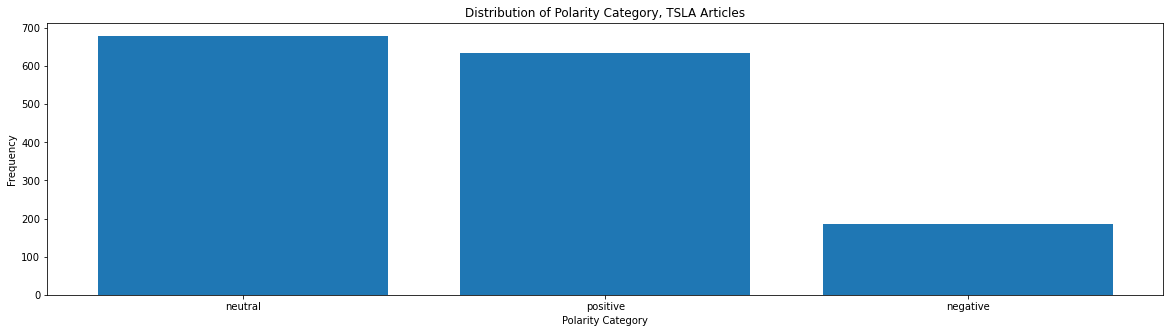

In [23]:
fig = plt.figure(figsize = (20, 5))
plt.bar(article_sentiment_summary_df.category, article_sentiment_summary_df.number_of_articles)
plt.ylabel('Frequency')
plt.xlabel('Polarity Category')
plt.title('Distribution of Polarity Category, TSLA Articles')

In [24]:
negative_sentences = []
positive_sentences = []
neutral_sentences = []

for i in range(0, len(article_sentiments['category'])):
    if article_sentiments['category'][i] == 'negative':
        negative_sentences.append(raw_article_text_textsplit[i])
        
    elif article_sentiments['category'][i] == 'positive':
        positive_sentences.append(raw_article_text_textsplit[i])
        
    else:
        neutral_sentences.append(raw_article_text_textsplit[i])

In [25]:
train_set = article_sentiment_df[:1501]
# test_set = article_sentiment_df[1125:]

In [26]:
docs = []

for i in range(0, len(train_set)):
    docs.append(([train_set['sentence'][i]], train_set['category'][i]))
    
print(docs[0])

(['Tesla-Hertz Deal Is Great News — for Carvana Stock - MarketWatch The move by \n        Hertz Global\n       to bulk up its global fleet of rentals with 100,000 electric vehicles from \n        Tesla\n       is great news for \n        Carvana,\n       which will work with Hertz to dispose of its unwanted cars.'], 'positive')


In [27]:
random.shuffle(docs)

## Unigram Model

To create the `unigram model`, I extracted the top 2000 most common unigrams within the document, as well as the polarity classification of the text. I then used the frequent unigrams to create a feature set that was then passed into an NLTK Naive Bayes classifier. The Naive Bayes classifier predicted the classification of text as `positive`, `negative`, or `neutral`, based on whether particular words were found within a sentence/piece of text. The model was able to do this because it was found that there were particular words (and/or phrases) which were more associated with negative sentences than they were with positive sentences. 

Thus, if the model detected a word that had very strong alignment with a particular category, it was more likely that the model will classify the text as that category.

In [67]:
all_words = []
for (sent, cat) in docs:
    for words in sent:
        word_tokenize = nltk.word_tokenize(words)
        for word in word_tokenize:
            all_words.append(word)
            
top_words = nltk.FreqDist(all_words)
most_common_words = top_words.most_common(2000)
word_features = [word for (word,count) in most_common_words]
len(set(all_words))

4520

In [69]:
featuresets = [(document_features(d, word_features), c) for (d, c) in docs]
# featuresets[0]

In [30]:
kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(featuresets):
    train_data = np.array(featuresets)[train]
    test_data = np.array(featuresets)[test]
    classifier = nltk.NaiveBayesClassifier.train(train_data)
    sum += nltk.classify.accuracy(classifier, test_data)

#storing the score in a variable 
acc1 = sum/5

print('The accuracy of unigram model is ~{}%'.format(round(acc1 * 100, 3)))

The accuracy of unigram model is ~45.267%


Using this approach, the model was able to classify text into the appropriate category ~45 percent of the time. Given that this data contains 3 categories, the model outperformed a random guess approach (since randonly guessing would be correct ~33 percent of the time). 

However, ~45.27 percent of the data is `neutral`. If this model was truly good as classifying, it would perform better than classifying all objects as the largest class. In fact, the simplest thing for the model to do is classify all objects as the largest category. Therefore, given that the largest category accounts for ~45.27 percent of the data, and the model achieved an accuracy score of ~45.27 percent, the model is a poor performer.

## Bigram Model

To create the `bigram model`, I extracted the top 2000 most common bigrams within the document, as well as the polarity classification of the text. I then used the frequent bigrams to create a feature set that was then passed into an NLTK Naive Bayes classifier. The Naive Bayes classifier predicted the classification of text as `positive`, `negative`, or `neutral`, based on whether particular words were found within a sentence/piece of text. The model was able to do this because it was found that there were particular words (and/or phrases) which were more associated with negative sentences than they were with positive sentences. 

Thus, if the model detected a phrase that had very strong alignment with a particular category, it was more likely that the model will classify the text as that category.

In [31]:
bigram_frequency = clean_text_data(raw_article_text)['bigrams']['frequency']

In [32]:
bigram_features = [bigram for (bigram, count) in bigram_frequency[:2000]]
bigram_features[:30]

[('stock', 'market'),
 ('Dow', 'Jones'),
 ('Industrial', 'Average'),
 ('Jones', 'Industrial'),
 ('General', 'Motors'),
 ('52-week', 'high'),
 ('trading', 'session'),
 ('Ford', 'Motor'),
 ('Group', 'Inc'),
 ('Workhorse', 'Group'),
 ('Motors', 'Co'),
 ('Motor', 'Co'),
 ('Elon', 'Musk'),
 ('Tesla', 'Stock'),
 ('company', 'achieved'),
 ('Composite', 'Index'),
 ('consecutive', 'day'),
 ('company', 'reached'),
 ('electric', 'vehicles'),
 ('electric', 'vehicle'),
 ('trading', 'day'),
 ('strong', 'trading'),
 ('Stock', 'Is'),
 ('outperforms', 'market'),
 ('Cathie', 'Wood'),
 ('stock', 'outperforms'),
 ('Tesla', 'stock'),
 ('The', 'stock'),
 ('second', 'consecutive'),
 ('February', '4th')]

In [68]:
bigram_featuresets = [(bi_document_features(d, bigram_features), c) for (d, c) in docs]
# bigram_featuresets[0]

In [34]:
kf = KFold(n_splits = 5)
sum = 0

for train, test in kf.split(bigram_featuresets):
    train_data2 = np.array(bigram_featuresets)[train]
    test_data2 = np.array(bigram_featuresets)[test]
    classifier2 = nltk.NaiveBayesClassifier.train(train_data2)
    sum += nltk.classify.accuracy(classifier2, test_data2)

acc2 = sum/5

print('The accuracy of the bigram model is ~{}%'.format(round(acc2 * 100, 3)))

The accuracy of the bigram model is ~45.267%


Using this approach, the model was able to classify text into the appropriate category ~45 percent of the time. Given that this data contains 3 categories, the model outperformed a random guess approach (since randonly guessing would be correct ~33 percent of the time). 

However, ~45.27 percent of the data is `neutral`. If this model was truly good as classifying, it would perform better than classifying all objects as the largest class. In fact, the simplest thing for the model to do is classify all objects as the largest category. Therefore, given that the largest category accounts for ~45.27 percent of the data, and the model achieved an accuracy score of ~45.27 percent, the model is a poor performer.

## Subjectivity Model with Naive Bayes

To create the `subjectivity model`, I trained a Naive Bayes classifier on the polarity and subjectivity of text within the documents. The output of this model was the classification of whether the text was `negative`, `positive`, or `neutral`.

It it likely that particular levels of subjectivity are more aligned with different classifications. For example, a it might be seen that a subjectivity level of 0 is highly associated with a classification of `neutral`. Thus, if the model detected that subjectivity levels had very strong alignments with a particular category, it was more likely that the model will classify the text as that category.

In [35]:
X = article_sentiment_df.iloc[:, [0, 2]].values
y = article_sentiment_df.iloc[:, 1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=1234)

In [36]:
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [37]:
nb_y_predictions = nb_classifier.predict(X_test)

In [38]:
nb_confusion_matrix = pd.DataFrame(confusion_matrix(y_test, nb_y_predictions))
nb_accuracy = round(accuracy_score(y_test, nb_y_predictions) * 100, 3)

In [39]:
nb_confusion_matrix

,0,1,2
0,106,0,37
1,0,510,0
2,0,3,469


In [40]:
print('The accuracy socre for the Naive Bayes classifier is ~{}%'.format(nb_accuracy))

The accuracy socre for the Naive Bayes classifier is ~96.444%


Using this approach, the model was able to classify text into the appropriate category ~96 percent of the time. Given that this data contains 3 categories, the model outperformed a random guess approach (since randonly guessing would be correct ~33 percent of the time). 

Additionally, ~45.27 percent of the data is `neutral`. If this model was truly good as classifying, it would perform better than classifying all objects as the largest class. In fact, the simplest thing for the model to do is classify all objects as the largest category. Therefore, given that the largest category accounts for ~45.27 percent of the data, and the model achieved an accuracy score of ~96.4 percent, the model is an excellent performer.

In [41]:
# y_train

In [42]:
# X_train

## Examining Sentence Types

### Neutral Sentences

In [43]:
neutral_sentences_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in neutral_sentences]
neutral_sentences_tagged_text = [nltk.pos_tag(token) for token in neutral_sentences_text_tokenized]
neutral_sentences_tagged_text[:5]

[[('Tesla', 'NNP'),
  ('Bulls', 'NNP'),
  ('Are', 'NNP'),
  ('Hiking', 'NNP'),
  ('Price', 'NNP'),
  ('Targets', 'NNS'),
  ('.', '.')],
 [('MarketWatch', 'NN'),
  ('Tuesday', 'NNP'),
  ('evening', 'NN'),
  (',', ','),
  ('Goldman', 'NNP'),
  ('Sachs', 'NNP'),
  ('analyst', 'NN'),
  ('Mark', 'NNP'),
  ('Delaney', 'NNP'),
  ('raised', 'VBD'),
  ('his', 'PRP$'),
  ('Tesla', 'NNP'),
  ('price', 'NN'),
  ('target', 'NN'),
  ('to', 'TO'),
  ('$1', 'VB'),
  (',', ','),
  ('125', 'CD'),
  ('from', 'IN'),
  ('$905', 'NN'),
  ('a', 'DT'),
  ('share', 'NN'),
  ('.', '.')],
 [('He', 'PRP'),
  ('is', 'VBZ'),
  ('a', 'DT'),
  ('Tesla', 'NNP'),
  ('bull', 'NN'),
  (',', ','),
  ('rating', 'NN'),
  ('shares', 'NNS'),
  ('of', 'IN'),
  ('the', 'DT'),
  ('electric-vehicle', 'NN'),
  ('giant', 'NN'),
  ('at', 'IN'),
  ('Buy', 'NNP'),
  ('.', '.')],
 [('Democrats', 'NNPS'),
  ('Release', 'NNP'),
  ('Billionaires', 'NNP'),
  ("'", 'POS'),
  ('Tax', 'NNP'),
  ('Plan', 'NN'),
  ('.', '.')],
 [('Here', 'RB'),

#### Adverbs

In [44]:
# tagging the adverb phrases 
neutral_advph_tags = []
for sentence in neutral_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                neutral_advph_tags.append(subtree)
                
# visualizing the adverb phrases
neutral_advph_phrases = []
for phrase in neutral_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    neutral_advph_phrases.append(temp)
    
print('First 10 adverb phrases for neutral sentences within Tesla articles are: ', neutral_advph_phrases[:10])

First 10 adverb phrases for neutral sentences within Tesla articles are:  ['as soon ', 'also enough ', 'not just ', 'anytime soon ', 'Maybe Not ', 'anywhere soon ', 'now very likely ', 'just not ']


In [45]:
# examining the freuqncy of the adverb phrases
neutral_advph_frequency = nltk.FreqDist(neutral_advph_phrases)
neutral_advph_frequency_words = []
neutral_advph_frequency_fs = []


print('Top adverb phrases for neutral sentences by frequency within the Tesla articles are: ')
for word, freq in neutral_advph_frequency.most_common(50):
    neutral_advph_frequency_words.append(word)
    neutral_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases for neutral sentences by frequency within the Tesla articles are: 
as soon  1
also enough  1
not just  1
anytime soon  1
Maybe Not  1
anywhere soon  1
now very likely  1
just not  1


The output above shows the top adverb phrases for neutral sentences (by frequencies). As the output shows, all phrases were found to have the same level of occurance. 

From examining the output, the phrases do not seem to have any particular sentiment associated with them.

Text(0.5, 1.0, 'Distribution of (Top 20) Neutral Adverb Phrases, Tesla Articles')

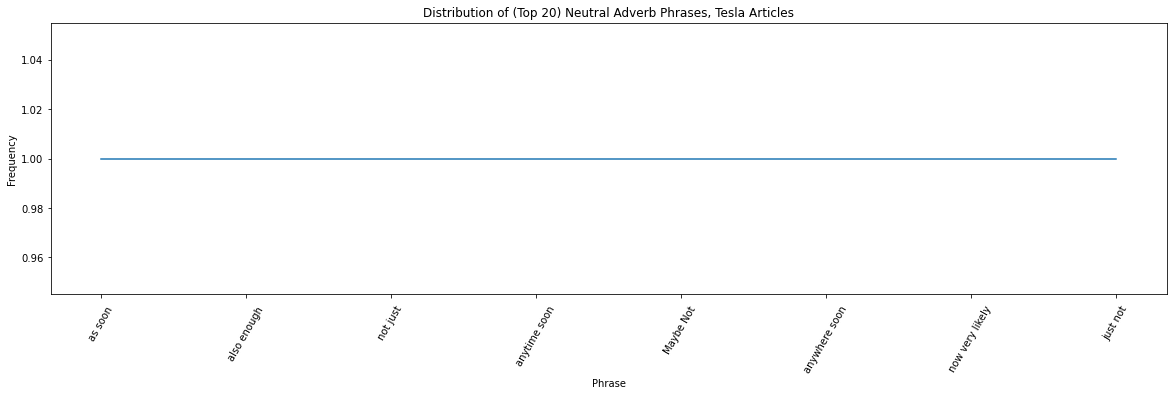

In [70]:
fig = plt.figure(figsize = (20, 5))
plt.plot(neutral_advph_frequency_words[:21], neutral_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Neutral Adverb Phrases, Tesla Articles')

#### Nouns

In [47]:
# tagging the noun phrases 
neutral_nph_tags = []
for sentence in neutral_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                neutral_nph_tags.append(subtree)
                
# visualizing the noun phrases
neutral_nph_phrases = []
for phrase in neutral_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    neutral_nph_phrases.append(temp)
    
print('First 10 noun phrases for neutral sentences within Tesla articles are: ', neutral_nph_phrases[:10])

First 10 noun phrases for neutral sentences within Tesla articles are:  ['Tesla ', 'Bulls ', 'Are ', 'Hiking ', 'Price ', 'Tuesday ', 'Goldman ', 'Sachs ', 'Mark ', 'Delaney ']


In [48]:
# examining the freuqncy of the noun phrases
neutral_nph_frequency = nltk.FreqDist(neutral_nph_phrases)
neutral_nph_frequency_words = []
neutral_nph_frequency_fs = []


print('Top noun phrases for neutral sentences by frequency within the Tesla articles are: ')
for word, freq in neutral_nph_frequency.most_common(50):
    neutral_nph_frequency_words.append(word)
    neutral_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases for neutral sentences by frequency within the Tesla articles are: 
Tesla  171
MarketWatch  99
Stock  66
the stock  43
Musk  31
EV  26
Elon  23
Is  18
Ford  16
China  16
Bitcoin  15
Again  14
CEO  14
Could  12
EVs  12
the Stock  12
Cathie  11
Wood  11
U.S.  11
Thursday  11
Tuesday  10
Isn  10
Know  9
Chinese  9
Has  9
Amazon  9
Street  9
Auto  9
the ADR  9
ARK  8
XPeng  8
Will  8
SpaceX  8
Wednesday  8
Wall  8
The stock  8
Monday  7
NIO  7
Jeff  7
Bezos  7
Says  7
Buy  6
Electric  6
Into  6
Market  6
$1  6
Shares  6
Day  6
Safety  6
Earnings  6


Text(0.5, 1.0, 'Distribution of (Top 20) Neutral Noun Phrases, Tesla Articles')

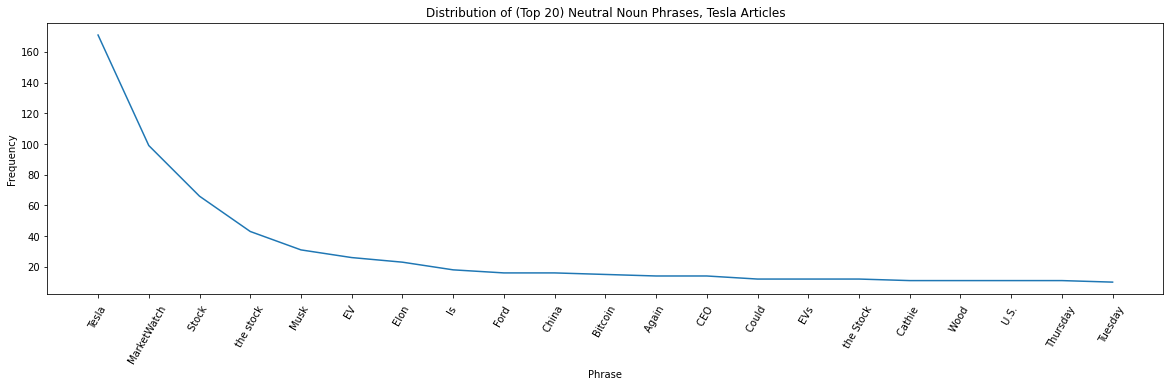

In [49]:
fig = plt.figure(figsize = (20, 5))
plt.plot(neutral_nph_frequency_words[:21], neutral_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Neutral Noun Phrases, Tesla Articles')

The table and graph above shows that the top noun for neutral phrases was Tesla. This is not very insightful because it is expected that `Tesla` would be found across all the sentiment categories.  However, the table also shows that all tokens identified were truly neutral because they do not seem to provide any context or sway the audience in any manner.

#### Verbs

In [50]:
# tagging the noun phrases 
neutral_vph_tags = []
for sentence in neutral_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                neutral_vph_tags.append(subtree)
                
# visualizing the noun phrases
neutral_vph_phrases = []
for phrase in neutral_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    neutral_vph_phrases.append(temp)
    
print('First 10 verb phrases for neutral sentences within Tesla articles are: ', neutral_vph_phrases[:10])

First 10 verb phrases for neutral sentences within Tesla articles are:  []


Surprisingly, there were no verb phrases identified. Despite this, multiple verbs were identified in previous steps of the analysis. Therefore, it suggests that there were no phrases which met the `verb` criteria after classification was conducted. Although this could be true, there is an element of error due to the classification exercise and the POS tagging algorithm which must be noted. 

### Negative Sentences

In [51]:
negative_sentences_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in negative_sentences]
negative_sentences_tagged_text = [nltk.pos_tag(token) for token in negative_sentences_text_tokenized]
negative_sentences_tagged_text[:5]

[[('Bears', 'NNS'),
  ('Are', 'VBP'),
  ('Holding', 'VBG'),
  ('Firm', 'NNP'),
  ('.', '.')],
 [('After', 'IN'),
  ('deliveries', 'NNS'),
  (',', ','),
  ('earnings', 'NNS'),
  (',', ','),
  ('and', 'CC'),
  ('Hertz', 'NNP'),
  ('news', 'NN'),
  (',', ','),
  ('Tesla', 'NNP'),
  ('bulls', 'NNS'),
  ('are', 'VBP'),
  ('doubling', 'VBG'),
  ('down', 'RP'),
  (',', ','),
  ('raising', 'VBG'),
  ('price', 'NN'),
  ('targets', 'NNS'),
  ('for', 'IN'),
  ('Tesla', 'NNP'),
  ('stock', 'NN'),
  ('.', '.')],
 [('Nearly', 'RB'),
  ('1', 'CD'),
  ('in', 'IN'),
  ('10', 'CD'),
  ('S', 'NNP'),
  ('P', 'NNP'),
  ('500', 'CD'),
  ('companies', 'NNS'),
  ('were', 'VBD'),
  ('scheduled', 'VBN'),
  ('to', 'TO'),
  ('release', 'VB'),
  ('their', 'PRP$'),
  ('third-quarter', 'JJ'),
  ('results', 'NNS'),
  (',', ','),
  ('plus', 'CC'),
  ('dozens', 'NNS'),
  ('of', 'IN'),
  ('small', 'JJ'),
  ('and', 'CC'),
  ('mid-cap', 'JJ'),
  ('firms', 'NNS'),
  ('.', '.')],
 [('MarketWatch', 'VB'),
  ('The', 'DT'),
  

#### Adverbs

In [52]:
# tagging the adverb phrases 
negative_advph_tags = []
for sentence in negative_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                negative_advph_tags.append(subtree)
                
# visualizing the adverb phrases
negative_advph_phrases = []
for phrase in negative_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    negative_advph_phrases.append(temp)
    
print('First 10 adverb phrases for negative sentences within Tesla articles are: ', negative_advph_phrases[:10])

First 10 adverb phrases for negative sentences within Tesla articles are:  ['ever so slowly ahead ', 'Not only ', 'down almost ', 'not only ', 'much lately ', 'certainly not ', 'down again ', 'just maybe ', 'away usually ']


In [53]:
# examining the freuqncy of the adverb phrases
negative_advph_frequency = nltk.FreqDist(negative_advph_phrases)
negative_advph_frequency_words = []
negative_advph_frequency_fs = []


print('Top adverb phrases for negative sentences by frequency within the Tesla articles are: ')
for word, freq in negative_advph_frequency.most_common(50):
    negative_advph_frequency_words.append(word)
    negative_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases for negative sentences by frequency within the Tesla articles are: 
ever so slowly ahead  1
Not only  1
down almost  1
not only  1
much lately  1
certainly not  1
down again  1
just maybe  1
away usually  1


Text(0.5, 1.0, 'Distribution of (Top 20) Negative Adverb Phrases, Tesla Articles')

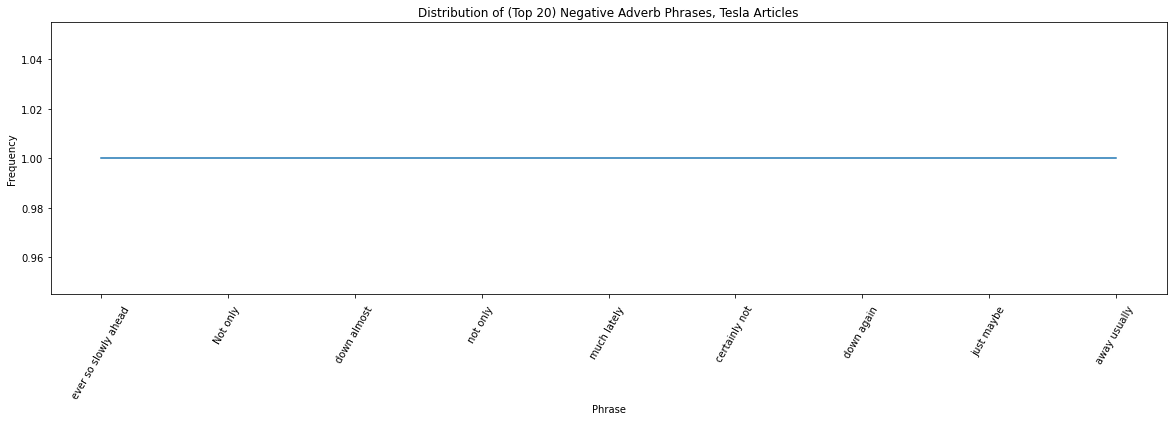

In [54]:
fig = plt.figure(figsize = (20, 5))
plt.plot(negative_advph_frequency_words[:21], negative_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Negative Adverb Phrases, Tesla Articles')

#### Nouns

In [55]:
# tagging the noun phrases 
negative_nph_tags = []
for sentence in negative_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                negative_nph_tags.append(subtree)
                
# visualizing the noun phrases
negative_nph_phrases = []
for phrase in negative_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    negative_nph_phrases.append(temp)
    
print('First 10 noun phrases for negative sentences within Tesla articles are: ', negative_nph_phrases[:10])

First 10 noun phrases for negative sentences within Tesla articles are:  ['Firm ', 'Hertz ', 'Tesla ', 'Tesla ', 'S ', 'P ', 'The Dow ', 'Industrials ', 'the S ', 'P ']


In [56]:
# examining the freuqncy of the noun phrases
negative_nph_frequency = nltk.FreqDist(negative_nph_phrases)
negative_nph_frequency_words = []
negative_nph_frequency_fs = []


print('Top noun phrases for negative sentences by frequency within the Tesla articles are: ')
for word, freq in negative_nph_frequency.most_common(50):
    negative_nph_frequency_words.append(word)
    negative_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases for negative sentences by frequency within the Tesla articles are: 
MarketWatch  79
Tesla  50
the stock  22
Co  20
Jones  19
Industrial  19
Average  19
Stock  17
Shares  17
Ford  17
Index  17
Dow  17
DJIA  17
P  15
the S  14
Monday  14
Motor  14
Inc  14
General  13
China  12
Wednesday  11
NIO  10
SPX  10
Tuesday  9
U.S.  9
EV  8
GM  8
ADR  8
Thursday  7
Group  7
Bitcoin  7
the day  7
the NASDAQ  7
Composite  7
COMP  7
the company  6
Crushed  6
Is  6
F  6
Workhorse  6
Stocks  5
News  5
Cathie  5
Wood  5
Electric-vehicle  4
May  4
The stock  4
Bad  4
Motors  4
the U.S.  4


Text(0.5, 1.0, 'Distribution of (Top 20) Negative Noun Phrases, Tesla Articles')

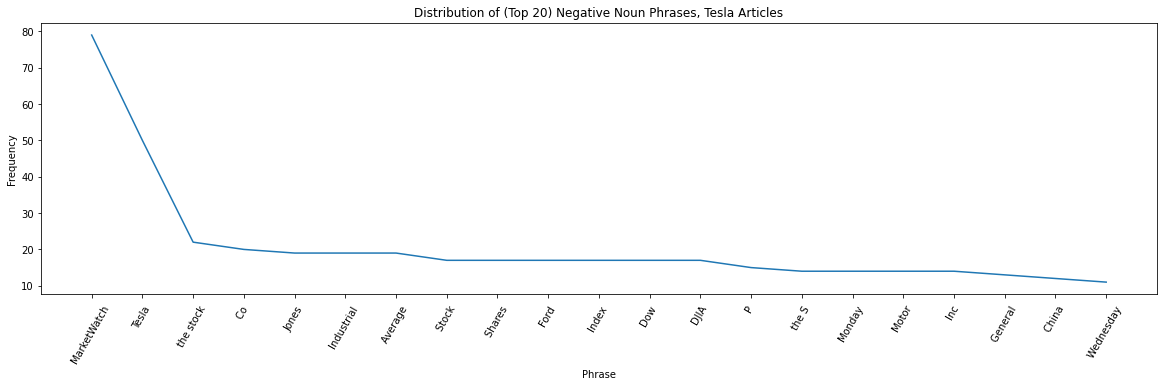

In [57]:
fig = plt.figure(figsize = (20, 5))
plt.plot(negative_nph_frequency_words[:21], negative_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Negative Noun Phrases, Tesla Articles')

#### Verbs

In [58]:
# tagging the noun phrases 
negative_vph_tags = []
for sentence in negative_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                negative_vph_tags.append(subtree)
                
# visualizing the noun phrases
negative_vph_phrases = []
for phrase in negative_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    negative_vph_phrases.append(temp)
    
print('First 10 verb phrases for negative sentences within Tesla articles are: ', negative_vph_phrases[:10])

First 10 verb phrases for negative sentences within Tesla articles are:  []


### Positive Sentences

In [59]:
positive_sentences_text_tokenized = [clean_text_data(sentence)['bigrams']['tokens'] for sentence in positive_sentences]
positive_sentences_tagged_text = [nltk.pos_tag(token) for token in positive_sentences_text_tokenized]
positive_sentences_tagged_text[:5]

[[('Tesla-Hertz', 'JJ'),
  ('Deal', 'NNP'),
  ('Is', 'VBZ'),
  ('Great', 'NNP'),
  ('News', 'NNP'),
  ('for', 'IN'),
  ('Carvana', 'NNP'),
  ('Stock', 'NNP'),
  ('MarketWatch', 'NNP'),
  ('The', 'DT'),
  ('move', 'NN'),
  ('by', 'IN'),
  ('Hertz', 'NNP'),
  ('Global', 'NNP'),
  ('to', 'TO'),
  ('bulk', 'VB'),
  ('up', 'RP'),
  ('its', 'PRP$'),
  ('global', 'JJ'),
  ('fleet', 'NN'),
  ('of', 'IN'),
  ('rentals', 'NNS'),
  ('with', 'IN'),
  ('100', 'CD'),
  (',', ','),
  ('000', 'CD'),
  ('electric', 'JJ'),
  ('vehicles', 'NNS'),
  ('from', 'IN'),
  ('Tesla', 'NNP'),
  ('is', 'VBZ'),
  ('great', 'JJ'),
  ('news', 'NN'),
  ('for', 'IN'),
  ('Carvana', 'NNP'),
  (',', ','),
  ('which', 'WDT'),
  ('will', 'MD'),
  ('work', 'VB'),
  ('with', 'IN'),
  ('Hertz', 'NNP'),
  ('to', 'TO'),
  ('dispose', 'VB'),
  ('of', 'IN'),
  ('its', 'PRP$'),
  ('unwanted', 'JJ'),
  ('cars', 'NNS'),
  ('.', '.')],
 [('The', 'DT'),
  ('bears', 'NNS'),
  ('aren', 'VBP'),
  ('t', 'JJ'),
  ('really', 'RB'),
  ('budg

#### Adverbs

In [60]:
# tagging the adverb phrases 
positive_advph_tags = []
for sentence in positive_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_advph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'ADVPH':
                positive_advph_tags.append(subtree)
                
# visualizing the adverb phrases
positive_advph_phrases = []
for phrase in positive_advph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    positive_advph_phrases.append(temp)
    
print('First 10 adverb phrases for positive sentences within Tesla articles are: ', positive_advph_phrases[:10])

First 10 adverb phrases for positive sentences within Tesla articles are:  ['as well ', 'pretty well ', 'up almost ', 'very well ', 'fun again ', 'just yet ', 'about much ', 'right now ', 'up just ', 'down again ']


In [61]:
# examining the freuqncy of the adverb phrases
positive_advph_frequency = nltk.FreqDist(positive_advph_phrases)
positive_advph_frequency_words = []
positive_advph_frequency_fs = []


print('Top adverb phrases for positive sentences by frequency within the Tesla articles are: ')
for word, freq in positive_advph_frequency.most_common(50):
    positive_advph_frequency_words.append(word)
    positive_advph_frequency_fs.append(freq)
    print(word, freq)

Top adverb phrases for positive sentences by frequency within the Tesla articles are: 
as well  2
pretty well  1
up almost  1
very well  1
fun again  1
just yet  1
about much  1
right now  1
up just  1
down again  1
as much  1
not necessarily  1
up again  1
so much  1
out so well  1
Right now  1
not so  1


Text(0.5, 1.0, 'Distribution of (Top 20) Positive Adverb Phrases, Tesla Articles')

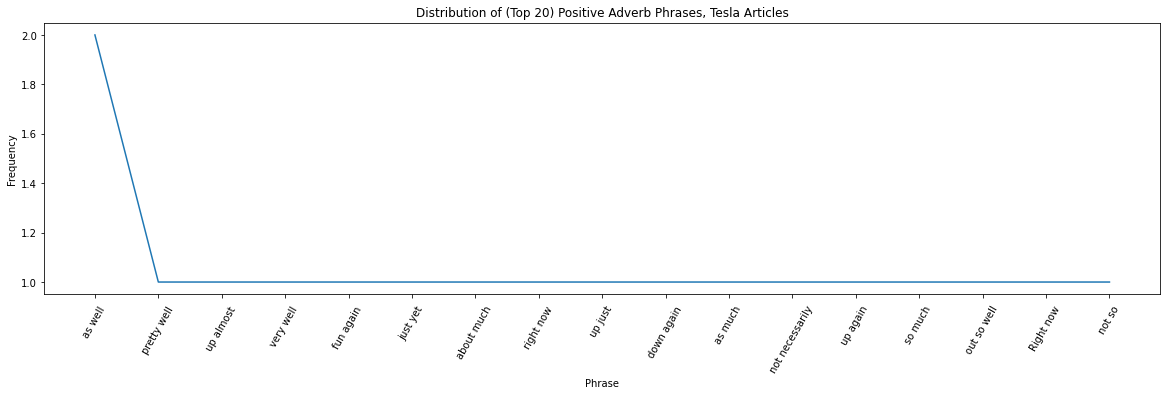

In [62]:
fig = plt.figure(figsize = (20, 5))
plt.plot(positive_advph_frequency_words[:21], positive_advph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Positive Adverb Phrases, Tesla Articles')

#### Nouns

In [63]:
# tagging the noun phrases 
positive_nph_tags = []
for sentence in positive_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'NPH':
                positive_nph_tags.append(subtree)
                
# visualizing the noun phrases
positive_nph_phrases = []
for phrase in positive_nph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    positive_nph_phrases.append(temp)
    
print('First 10 noun phrases for positive sentences within Tesla articles are: ', positive_nph_phrases[:10])

First 10 noun phrases for positive sentences within Tesla articles are:  ['Deal ', 'Great ', 'News ', 'Carvana ', 'Stock ', 'MarketWatch ', 'The move ', 'Hertz ', 'Global ', 'Tesla ']


In [64]:
# examining the freuqncy of the noun phrases
positive_nph_frequency = nltk.FreqDist(positive_nph_phrases)
positive_nph_frequency_words = []
positive_nph_frequency_fs = []


print('Top noun phrases for positive sentences by frequency within the Tesla articles are: ')
for word, freq in positive_nph_frequency.most_common(50):
    positive_nph_frequency_words.append(word)
    positive_nph_frequency_fs.append(freq)
    print(word, freq)

Top noun phrases for positive sentences by frequency within the Tesla articles are: 
MarketWatch  253
Tesla  154
Inc  121
Co  109
the company  103
the stock  87
General  77
Jones  75
Industrial  74
Average  74
Index  74
DJIA  71
NIO  70
Ford  69
Motor  65
Group  65
Workhorse  63
ADR  58
Shares  57
Stock  55
the Dow  54
P  45
Composite  40
the NASDAQ  38
COMP  38
Musk  37
Thursday  37
Friday  36
the S  35
Wednesday  34
Elon  34
SPX  33
EV  31
Tuesday  29
Monday  29
GM  27
China  26
February  24
$42.96  23
CEO  22
$66.99  22
January  22
Dow  21
Bitcoin  20
WKHS  20
$63.44  20
April  20
U.S.  18
The NIO  18
March  17


Text(0.5, 1.0, 'Distribution of (Top 20) Positive Noun Phrases, Tesla Articles')

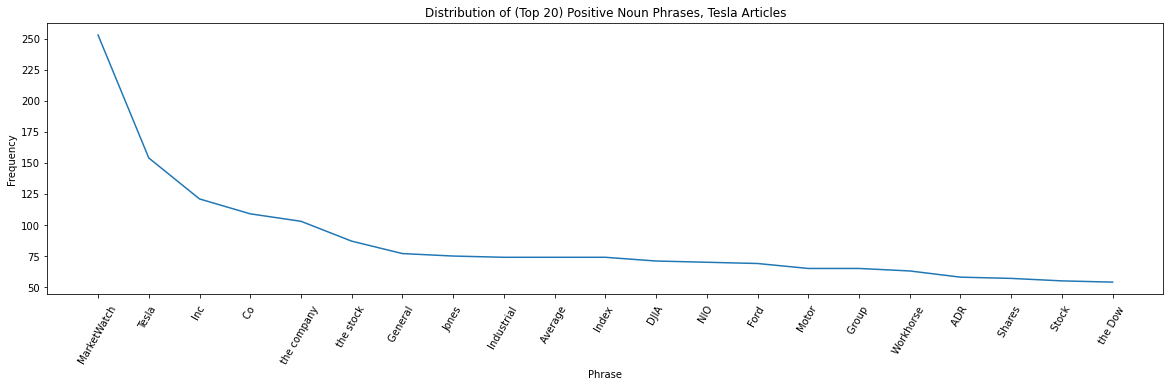

In [65]:
fig = plt.figure(figsize = (20, 5))
plt.plot(positive_nph_frequency_words[:21], positive_nph_frequency_fs[:21])
plt.xticks(rotation = 60)
plt.ylabel('Frequency')
plt.xlabel('Phrase')
plt.title('Distribution of (Top 20) Positive Noun Phrases, Tesla Articles')

#### Verbs

In [66]:
# tagging the noun phrases 
positive_vph_tags = []
for sentence in positive_sentences_tagged_text:
    if len(sentence) > 0:
        tree = chunk_parser_nph.parse(sentence)
        for subtree in tree.subtrees():
            if subtree.label() == 'VPH':
                positive_vph_tags.append(subtree)
                
# visualizing the noun phrases
positive_vph_phrases = []
for phrase in positive_vph_tags:
    temp = ''
    for w, t in phrase:
        temp += w+ ' '    
    positive_vph_phrases.append(temp)
    
print('First 10 verb phrases for positive sentences within Tesla articles are: ', positive_vph_phrases[:10])

First 10 verb phrases for positive sentences within Tesla articles are:  []


## Conclusions

After model creation and analysis, it was found that it is very difficult to build classifiers to appropriately classify text documents. Despite the challenges, I was able to utilize the subjectivity of phrases within text documents and develop a `Naive Bayes` classifier model with had an accuracy of ~96 percent. 

It was also found that examining the text at the sentiment classification level and part-of-speech provided no further context than simply analyzing the text at the part-of-speech level only. This is because the words and phrases identified at each sentiment classification and part-of-speech level was identical. The difference, therefore, would most likely be function of greater context within the text document. If this is true, then more sophisticated classification models would need to be investigated (such as deep neural network or LSTM models). Said differently, it is possible that the classification of phrases within the text documents rely on long-term dependencies within the text, and this is not caputured when using methods such as `bag of words`.

This also provides insight as to why the subjectivity model outperformed the unigram and bigram models. The subjectivity score given to each phrase within the text documents would be a function of long-term dependencies. Therefore, through using the subjectivity as an input, the model was able to identify stronger relationships between the text and the classifications, allowing it to predict values with a higher level of accuracy.

To conclude, recall that the initial goal was to be able to identify a difference in writing styles or the way that information is presented between financial articles and storytelling.

Based on the corpus statistics and corpora comparisons previously performed, it is possible to identify a difference in writing styles. Combining the previous knowledge with the newly found insights, it can be inferred that financial articles primarily present facts in the form of fluctuation, comparison, and performance. Whereas storytelling is very descriptive, containing much less facts and comparisons when compared to the financial articles. 

Additionally, previous investigation showed that sentences within storytelling are typically longer than sentences within financial articles. Although the difference could be negligible in this instance, this insight further solidifies inferences from the previous analysis, where it was found that the financial articles contained a large portion of periods and Hamlet contained a large portion of commas.

Lastly, this analysis showed that work should be done to understand long-term dependency between text, as this could allow for better classification and prediction (when necessary).